In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams['figure.figsize'] = fig_size
from matplotlib import rc
import seaborn as sns
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
import xgboost
from xgboost import XGBRegressor

# Primera fase: Análisis
La fase de análisis se refiere al proceso crítico de realizar investigaciones iniciales sobre datos para descubrir patrones, detectar anomalías, probar hipótesis y verificar supuestos con la ayuda de estadísticas y representaciones gráficas. Nuestro objetivo es predecir el precio de inmuebles, dependiendo de todas las otras variables. El precio, en este caso, es nuestra variable dependiente, mientras que todas las demás características son variables independientes. 

## Obtención de datos de viviendas 
  El conjunto de datos utilizado en este proyecto proviene del dataset publicado en kaggle.com, llamado "House Sales in King County, USA". Este conjunto de datos contiene precios de venta de viviendas para el condado de King, que incluye Seattle, en Estados Unidos. Incluye casas vendidas entre mayo de 2014 y mayo de 2015.

In [2]:
df = pd.read_csv('Dataset/kc_house_data.csv')
df.head()

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

## Limpieza y análisis exploratorio inicial de los datos obtenidos
Después de haber recopilado toda la información, se analizarán y evaluarán los datos obtenidos para lograr elegir un subgrupo de datos para poder resolver el problema definido.

In [3]:
df.shape

(21613, 21)

In [4]:
#Tabla con los precios del dataset
precios = df['price']
precios.head()

0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [5]:
#Precio mínimo en el dataset
min_precio = np.amin(precios)
#Precio máximo en el dataset
max_precio = np.amax(precios)
#Media del precio en el dataset
media_precio = np.mean(precios)
#Mediana del precio en el dataset
mediana_precio = np.median(precios)
#Desviación estándar del precio en el dataset
std_precio = np.std(precios)

#Resultados
print("Resultados:")
print("Precio mínimo: ${}".format(min_precio))
print("Precio máximo: ${}".format(max_precio))
print("Media: ${}".format(media_precio))
print("Mediana: ${}".format(mediana_precio))
print("Desviación Estándar: ${}".format(std_precio))

Resultados:
Precio mínimo: $75000.0
Precio máximo: $7700000.0
Media: $540088.1417665294
Mediana: $450000.0
Desviación Estándar: $367118.7031813722


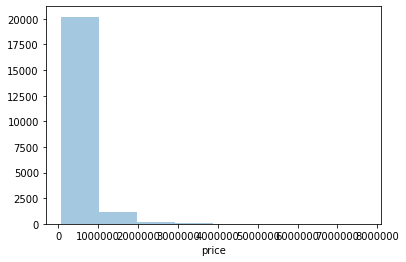

In [6]:
#Distribución del precio
sns.distplot(df['price'], kde=False, bins=8)

### Correlacion entre las variables y precio
Tener demasiadas funciones en un modelo no siempre es algo bueno porque puede causar un sobreajuste y resultados peores cuando queremos predecir valores para un nuevo conjunto de datos. Por lo tanto, si una característica no mejora mucho su modelo, no agregarlo puede ser una mejor opción.

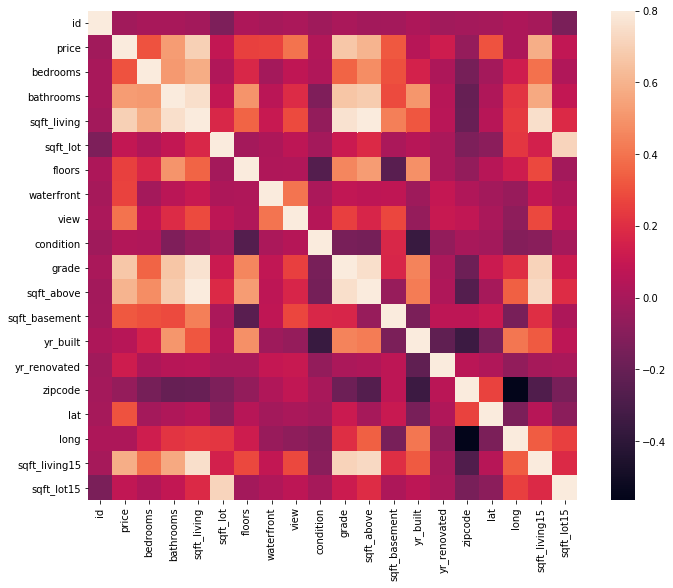

In [7]:
#Matriz de correlacion
matcorr = df.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(matcorr, vmax = .8, square = True)

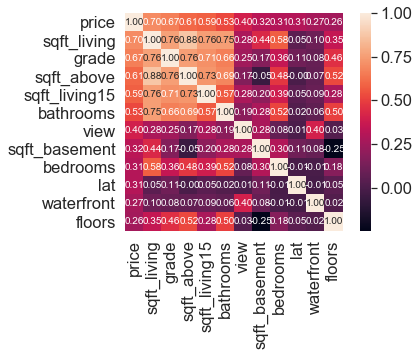

In [8]:
#Primeras 12 variables mas correlacionadas
n = 12 #numero de variables a utilizar para la matriz
col = matcorr.nlargest(n, 'price')['price'].index
cm = np.corrcoef(df[col].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, annot = True, square = True, fmt = '.2f', annot_kws = {'size': 10}, yticklabels = col.values, xticklabels = col.values)
plt.show()

In [9]:
#Tabla con las variables mas correlacionadas con precio
mas_corr = pd.DataFrame(col)
mas_corr.columns = ['Variables mas correlacionadas']
mas_corr

Variables mas correlacionadas
0                          price
1                    sqft_living
2                          grade
3                     sqft_above
4                  sqft_living15
5                      bathrooms
6                           view
7                  sqft_basement
8                       bedrooms
9                            lat
10                    waterfront
11                        floors

## 	Consolidación del dataset final para pruebas
Para el propósito del proyecto, el conjunto de datos se ha preprocesado de la siguiente manera:

In [10]:
#Buscando valores nulos en el dataset
nan_rows = df[df.isnull().any(1)]
nan_rows

Empty DataFrame
Columns: [id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

[0 rows x 21 columns]

In [11]:
#Dataset final a utilizar, con las 12 caracteristicas mas correlacionadas
dataset = df.copy().drop(['id', 'floors', 'date', 'sqft_lot', 'yr_renovated', 'zipcode', 'long', 'sqft_lot15', 'condition'], axis = 1)
dataset.head()

price  bedrooms  bathrooms  sqft_living  waterfront  view  grade  \
0  221900.0         3       1.00         1180           0     0      7   
1  538000.0         3       2.25         2570           0     0      7   
2  180000.0         2       1.00          770           0     0      6   
3  604000.0         4       3.00         1960           0     0      7   
4  510000.0         3       2.00         1680           0     0      8   

   sqft_above  sqft_basement  yr_built      lat  sqft_living15  
0        1180              0      1955  47.5112           1340  
1        2170            400      1951  47.7210           1690  
2         770              0      1933  47.7379           2720  
3        1050            910      1965  47.5208           1360  
4        1680              0      1987  47.6168           1800

## Análisis exploratorio exhaustivo del dataset final
Veremos y analizaremos las relaciones existentes entre el precio y las demás características de nuestro conjunto de datos final.

### Gráficos de dispersión

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


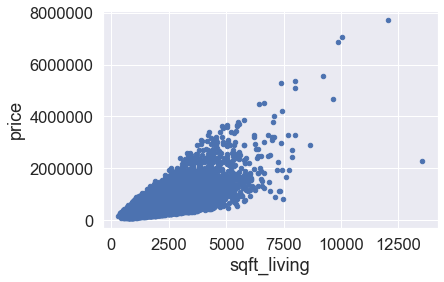

In [12]:
#Sqft_living vs precio
dataset.plot.scatter('sqft_living', 'price')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


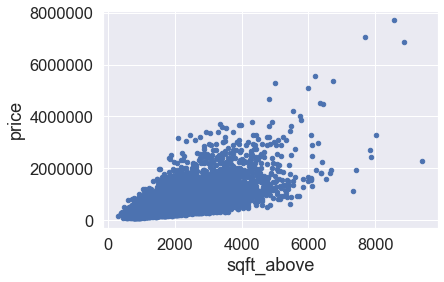

In [13]:
#Sqft_above vs precio
dataset.plot.scatter('sqft_above', 'price')

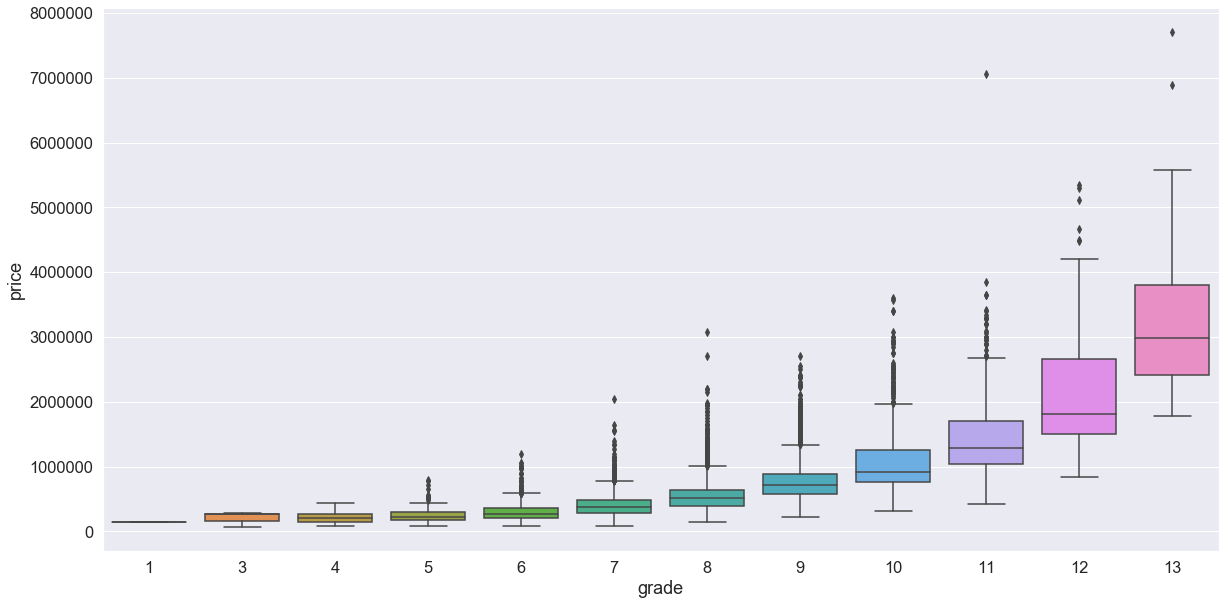

In [14]:
#Calificacion vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['grade'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


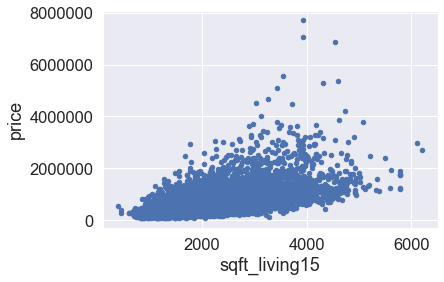

In [15]:
#Sqft_living15 vs precio
dataset.plot.scatter('sqft_living15', 'price')

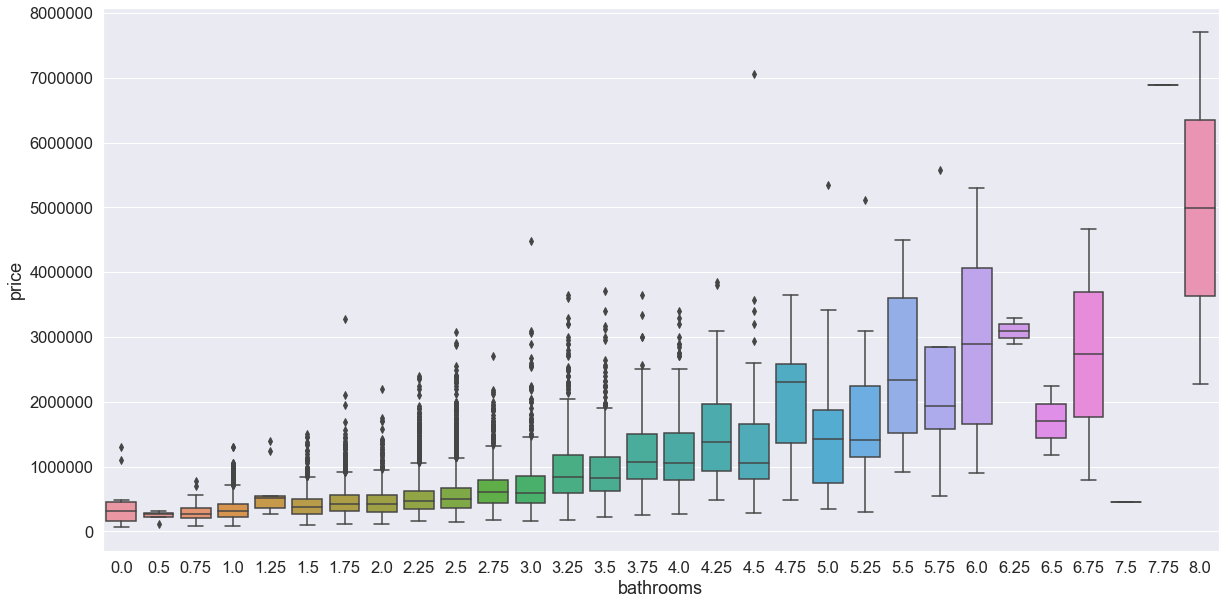

In [16]:
#Baños vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['bathrooms'], y=dataset['price'])

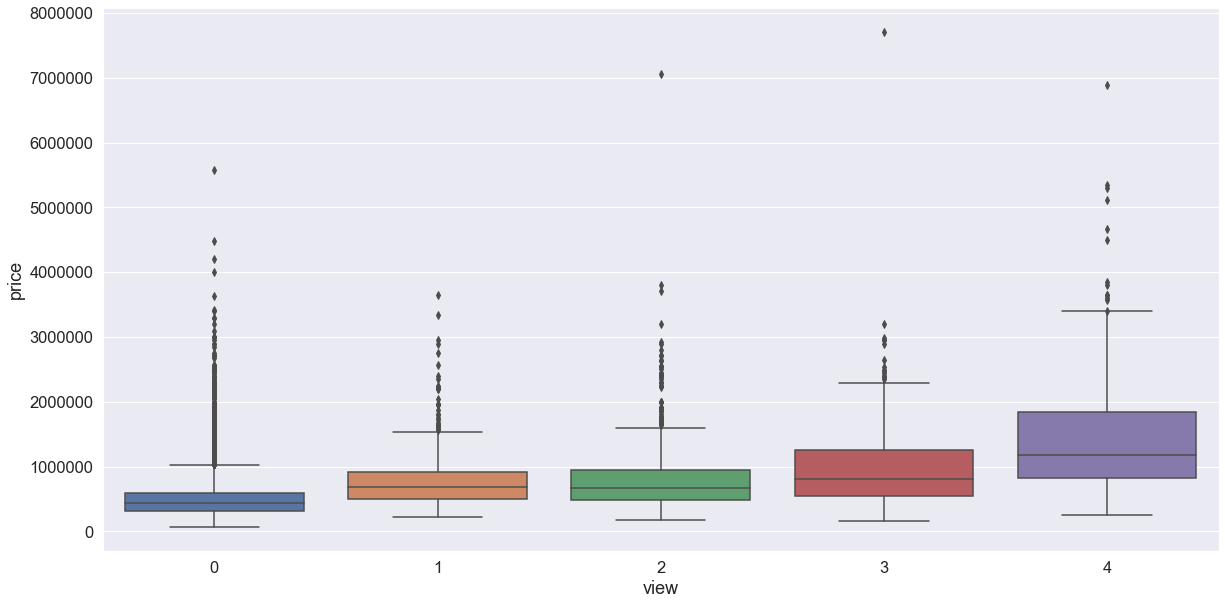

In [17]:
#Vista vs precio
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['view'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


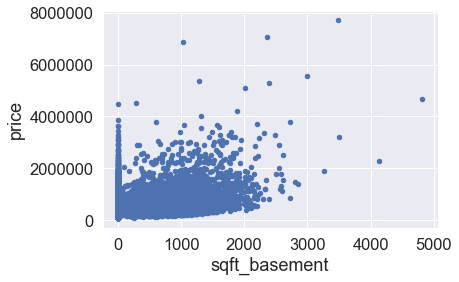

In [18]:
#Sqft_basement vs precio
dataset.plot.scatter('sqft_basement', 'price')

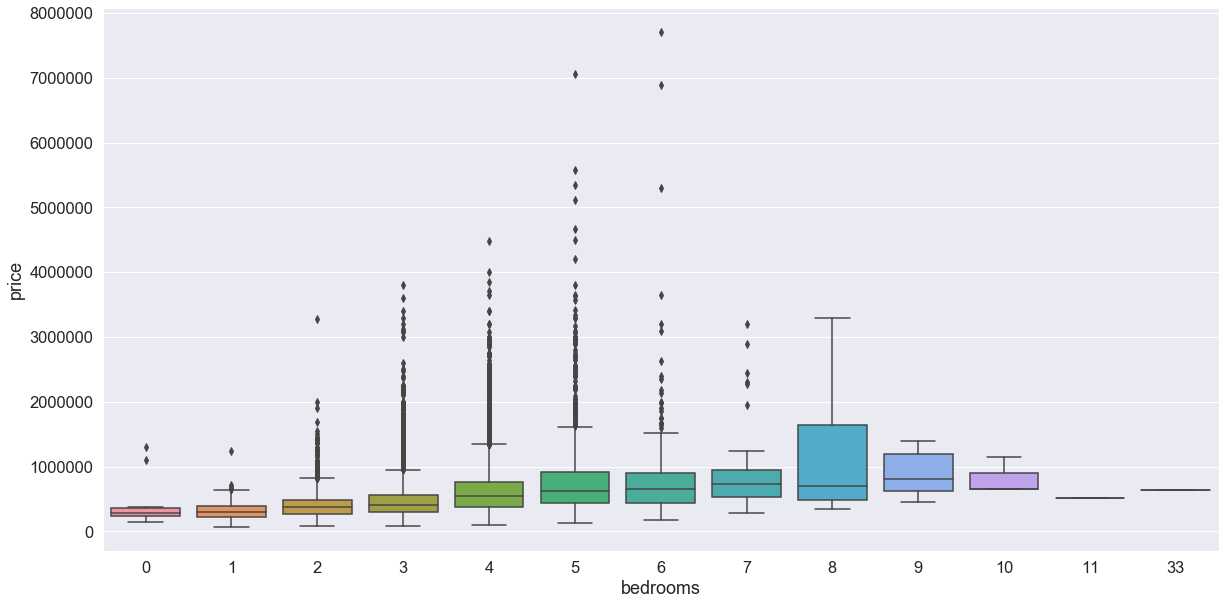

In [19]:
#Habitaciones vs precio
#df.plot.scatter('bedrooms', 'price')
f, ax = plt.subplots(figsize=(20, 10))
sns.boxplot(x=dataset['bedrooms'], y=dataset['price'])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


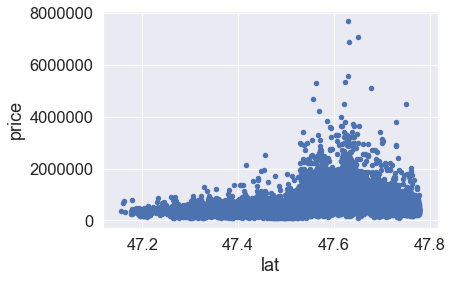

In [20]:
#Latitud vs precio
dataset.plot.scatter('lat', 'price')

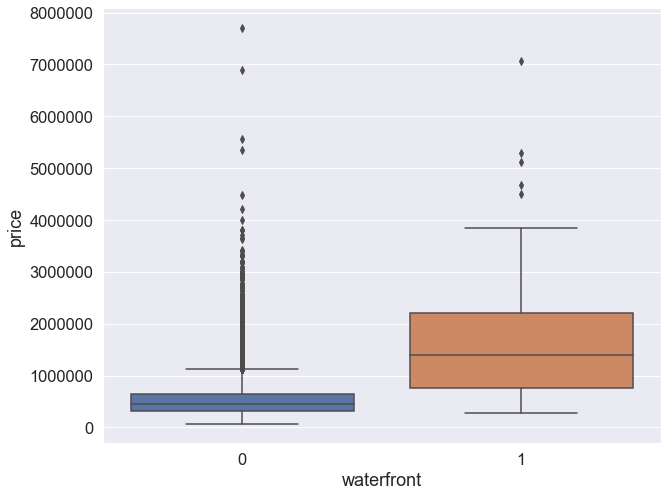

In [21]:
#Frente al mar vs precio
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x=dataset['waterfront'], y=dataset['price'])

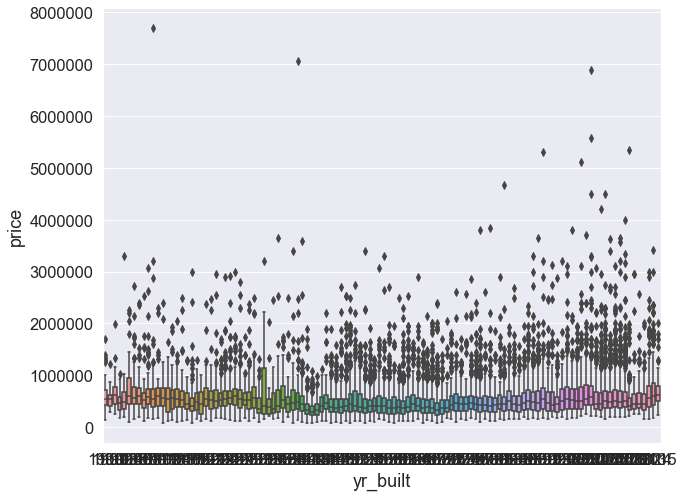

In [22]:
#Año de construcción vs precio
f, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(x=dataset['yr_built'], y=dataset['price'])

# Fase 2: Diseño

## Elaboración de hipótesis de trabajo en base del estudio exploratorio previo.

## Procesamiento de información y generación de características para modelado.

### División de los datos
Para esta sección tomaremos el conjunto de datos de vivienda y los dividiremos en subconjuntos de entrenamiento y evaluación. Por lo general, los datos también se mezclan en un orden aleatorio al crear los subconjuntos de entrenamiento y prueba para eliminar cualquier sesgo en el orden del conjunto de datos.

In [23]:
#Tabla que contiene las caracteristicas de los inmuebles, sin la variable dependiente, precio, la cual intentaremos predecir
carac = dataset.drop(['price'], axis = 1)
carac.head()

bedrooms  bathrooms  sqft_living  waterfront  view  grade  sqft_above  \
0         3       1.00         1180           0     0      7        1180   
1         3       2.25         2570           0     0      7        2170   
2         2       1.00          770           0     0      6         770   
3         4       3.00         1960           0     0      7        1050   
4         3       2.00         1680           0     0      8        1680   

   sqft_basement  yr_built      lat  sqft_living15  
0              0      1955  47.5112           1340  
1            400      1951  47.7210           1690  
2              0      1933  47.7379           2720  
3            910      1965  47.5208           1360  
4              0      1987  47.6168           1800

In [24]:
#Tabla que contiene los precios de los inmuebles en el dataset
precios = pd.DataFrame(dataset['price'])
precios.head()

price
0  221900.0
1  538000.0
2  180000.0
3  604000.0
4  510000.0

In [98]:
#Division de las variables en entrenamiento y evaluacion
x_ent, x_eval, y_ent, y_eval = train_test_split(carac, precios, test_size=0.2)

# Fase 3: Implementación
En esta tercera sección del proyecto, desarrollaremos las herramientas y técnicas necesarias para que un modelo haga una predicción. 

## Generación de modelos predictivos utilizando machine learning.
Una vez que se limpian los datos, procederemos a realizar nuestros modelos de aprendizaje automático. El precio de venta es en dólares e intentaremos predecirlo.

### Regresión Lineal
En estadísticas, regresión lineal es una aproximación para modelar la relación entre una variable escalar dependiente "Y" y una o mas variables explicativas nombradas con "X". Lo que haremos es "dibujar una recta" que nos indicará la tendencia de un conjunto de datos continuos. 

In [33]:
lr = linear_model.LinearRegression()
modelo_1 = lr.fit(x_ent, y_ent)
print('Coeficientes: ', modelo_1.coef_)
print('Intersección: ', modelo_1.intercept_)

Coeficientes:  [[-3.52322774e+04  5.02792681e+04  1.13813658e+02  6.08067411e+05
   4.71204846e+04  9.99940673e+04  6.61851398e+01  4.76285182e+01
  -3.03381083e+03  5.61280827e+05  1.23779088e+01]]
Intersección:  [-21337298.53908994]


In [34]:
prediccion_1 = modelo_1.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_1)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_1))
r2 = metrics.r2_score(y_eval, prediccion_1)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 129853.01266887368
Error cuadrático medio: 200334.6059925476
R-cuadrado: 0.6935509926211783


In [35]:
#Tabla que contiene los resultados de las metricas de evaluacion de cada modelo
evaluacion = pd.DataFrame({'Modelo': [], 'Error medio absoluto':[], 'Error cuadrático medio':[], 'R-cuadrado':[],})
r = evaluacion.shape[0]
evaluacion.loc[r] = ['Regresion lineal', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)
evaluacion

Modelo  Error medio absoluto  Error cuadrático medio  R-cuadrado
0  Regresion lineal         129853.012669           200334.605993    0.693551

### Cross Validation y RFE
La validación cruzada (Cross Validation en ingles) es una técnica utilizada para evaluar modelos de ML mediante la capacitación de varios modelos en subconjuntos de datos de entrada disponibles y evaluándolos en el subconjunto complementario de datos, consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes las particiones.
RFE o Eliminación de Características Recursivas consiste en la selección de características automáticamente de los datos que más contribuyen a la variable de predicción. Tener características irrelevantes en los datos puede disminuir la precisión de muchos modelos, especialmente los algoritmos lineales como la regresión lineal y logística.

#### RFE con 3 caracteristicas a elegir

In [36]:
#RFE
lr = linear_model.LinearRegression()
rfe = RFE(lr, n_features_to_select=3)

In [37]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe.fit(X, Y)

In [38]:
print(rfe.support_)
print(rfe.ranking_)

[False False False  True False  True False False False  True False]
[4 3 6 1 2 1 7 8 5 1 9]


In [39]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'sqft_living'), (1, 'view'), (1, 'yr_built'), (2, 'waterfront'), (3, 'bedrooms'), (4, 'price'), (5, 'sqft_basement'), (6, 'bathrooms'), (7, 'grade'), (8, 'sqft_above'), (9, 'lat')]


In [40]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe.transform(X)
nueva_x

array([[ 0.    ,  7.    , 47.5112],
       [ 0.    ,  7.    , 47.721 ],
       [ 0.    ,  6.    , 47.7379],
       ...,
       [ 0.    ,  7.    , 47.5944],
       [ 0.    ,  8.    , 47.5345],
       [ 0.    ,  7.    , 47.5941]])

In [43]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_2 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [    7    10    12 ... 21596 21601 21602]
Division de entrenamiento:  [    0     4     5 ... 21606 21611 21612]
Division de evaluacion:  [    1     2     3 ... 21608 21609 21610]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [    4     5     8 ... 21595 21604 21605]
Division de entrenamiento:  [    0     1     2 ... 21609 21610 21612]
Division de evaluacion:  [   21    24    26 ... 21599 21603 21611]
Division de entrenamiento:  [    1     2     3 ... 21609 21610 21611]
Division de evaluacion:  [    0     6     9 ... 21598 21606 21612]


In [44]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.5486419099081103, 0.5218576390291938, 0.5349806625659355, 0.5556450485783445, 0.5727379555707779]
Promedio de las puntaciones 0.5467726431304725


In [45]:
prediccion_2 = modelo_2.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_2)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_2))
r2 = metrics.r2_score(Y_eval, prediccion_2)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 151552.10459983133
Error cuadrático medio: 238439.66181111633
R-cuadrado: 0.5727379555707779


In [46]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (3)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

Modelo  Error medio absoluto  Error cuadrático medio  \
0              Regresion lineal         129853.012669           200334.605993   
1  RFE con Cross Validation (3)         151552.104600           238439.661811   

   R-cuadrado  
0    0.693551  
1    0.572738

#### RFE con 5 caracteristicas a elegir

In [47]:
#RFE
lr = linear_model.LinearRegression()
rfe_2 = RFE(lr, n_features_to_select=5)

In [50]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe_2.fit(X, Y)

In [51]:
print(rfe_2.support_)
print(rfe_2.ranking_)

[False  True False  True  True  True False False False  True False]
[2 1 4 1 1 1 5 6 3 1 7]


In [52]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe_2.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'bedrooms'), (1, 'sqft_living'), (1, 'view'), (1, 'waterfront'), (1, 'yr_built'), (2, 'price'), (3, 'sqft_basement'), (4, 'bathrooms'), (5, 'grade'), (6, 'sqft_above'), (7, 'lat')]


In [53]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe_2.transform(X)
nueva_x

array([[ 1.    ,  0.    ,  0.    ,  7.    , 47.5112],
       [ 2.25  ,  0.    ,  0.    ,  7.    , 47.721 ],
       [ 1.    ,  0.    ,  0.    ,  6.    , 47.7379],
       ...,
       [ 0.75  ,  0.    ,  0.    ,  7.    , 47.5944],
       [ 2.5   ,  0.    ,  0.    ,  8.    , 47.5345],
       [ 0.75  ,  0.    ,  0.    ,  7.    , 47.5941]])

In [66]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_3 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [    6    12    31 ... 21586 21602 21609]
Division de entrenamiento:  [    0     1     3 ... 21609 21611 21612]
Division de evaluacion:  [    2     4    11 ... 21597 21608 21610]
Division de entrenamiento:  [    0     1     2 ... 21608 21609 21610]
Division de evaluacion:  [    5    14    16 ... 21606 21611 21612]
Division de entrenamiento:  [    0     2     4 ... 21610 21611 21612]
Division de evaluacion:  [    1     3     9 ... 21599 21605 21607]
Division de entrenamiento:  [    1     2     3 ... 21610 21611 21612]
Division de evaluacion:  [    0     7     8 ... 21596 21600 21603]


In [67]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.5662380863818554, 0.5847460463339476, 0.5862589302058294, 0.5994148151937905, 0.608541858181082]
Promedio de las puntaciones 0.589039947259301


In [68]:
prediccion_3 = modelo_3.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_3)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_3))
r2 = metrics.r2_score(Y_eval, prediccion_3)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 149440.30169845084
Error cuadrático medio: 226925.44261960214
R-cuadrado: 0.608541858181082


In [69]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (5)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

Modelo  Error medio absoluto  Error cuadrático medio  \
0              Regresion lineal         129853.012669           200334.605993   
2  RFE con Cross Validation (5)         149440.301698           226925.442620   
1  RFE con Cross Validation (3)         151552.104600           238439.661811   

   R-cuadrado  
0    0.693551  
2    0.608542  
1    0.572738

#### RFE con 7 caracteristicas a elegir

In [70]:
#RFE
lr = linear_model.LinearRegression()
rfe_3 = RFE(lr, n_features_to_select=7)

In [71]:
X = dataset.copy().drop(['price'], axis = 1)
Y = dataset['price']
modelo = rfe_3.fit(X, Y)

In [72]:
print(rfe_3.support_)
print(rfe_3.ranking_)

[ True  True False  True  True  True False False  True  True False]
[1 1 2 1 1 1 3 4 1 1 5]


In [73]:
print("Categorias ordenadas por su rango:")
print(sorted(zip(map(lambda x: round(x, 4), rfe_3.ranking_), dataset.columns)))

Categorias ordenadas por su rango:
[(1, 'bedrooms'), (1, 'price'), (1, 'sqft_basement'), (1, 'sqft_living'), (1, 'view'), (1, 'waterfront'), (1, 'yr_built'), (2, 'bathrooms'), (3, 'grade'), (4, 'sqft_above'), (5, 'lat')]


In [74]:
#Tenemos un nuevo arreglo x, con las columnas elegidas por el RFE
nueva_x = rfe_3.transform(X)
nueva_x

array([[3.00000e+00, 1.00000e+00, 0.00000e+00, ..., 7.00000e+00,
        1.95500e+03, 4.75112e+01],
       [3.00000e+00, 2.25000e+00, 0.00000e+00, ..., 7.00000e+00,
        1.95100e+03, 4.77210e+01],
       [2.00000e+00, 1.00000e+00, 0.00000e+00, ..., 6.00000e+00,
        1.93300e+03, 4.77379e+01],
       ...,
       [2.00000e+00, 7.50000e-01, 0.00000e+00, ..., 7.00000e+00,
        2.00900e+03, 4.75944e+01],
       [3.00000e+00, 2.50000e+00, 0.00000e+00, ..., 8.00000e+00,
        2.00400e+03, 4.75345e+01],
       [2.00000e+00, 7.50000e-01, 0.00000e+00, ..., 7.00000e+00,
        2.00800e+03, 4.75941e+01]])

In [75]:
#Cross validation
puntuaciones = []
lr = linear_model.LinearRegression()
kf = KFold(n_splits = 5, shuffle = True)
for ent_index, eval_index in kf.split(nueva_x):
    print("Division de entrenamiento: ", ent_index)
    print("Division de evaluacion: ", eval_index)
    X_ent, X_eval, Y_ent, Y_eval = nueva_x[ent_index], nueva_x[eval_index], Y[ent_index], Y[eval_index]
    modelo_4 = lr.fit(X_ent, Y_ent)
    puntuaciones.append(lr.score(X_eval, Y_eval))

Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [   17    18    27 ... 21573 21579 21591]
Division de entrenamiento:  [    0     1     2 ... 21609 21610 21611]
Division de evaluacion:  [   11    14    20 ... 21601 21607 21612]
Division de entrenamiento:  [    1     2     3 ... 21609 21611 21612]
Division de evaluacion:  [    0     6     8 ... 21606 21608 21610]
Division de entrenamiento:  [    0     1     2 ... 21610 21611 21612]
Division de evaluacion:  [    5     7     9 ... 21587 21597 21604]
Division de entrenamiento:  [    0     5     6 ... 21608 21610 21612]
Division de evaluacion:  [    1     2     3 ... 21603 21609 21611]


In [76]:
print('Puntaciones: ', puntuaciones)
print('Promedio de las puntaciones', np.mean(puntuaciones))

Puntaciones:  [0.646786519092296, 0.6603880973269842, 0.6515385326357109, 0.6391156902802795, 0.6143334583429226]
Promedio de las puntaciones 0.6424324595356387


In [77]:
prediccion_4 = modelo_4.predict(X_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( Y_eval, prediccion_4)
rmse = np.sqrt(metrics.mean_squared_error(Y_eval, prediccion_4))
r2 = metrics.r2_score(Y_eval, prediccion_4)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 138245.5126321474
Error cuadrático medio: 241293.95390403274
R-cuadrado: 0.6143334583429226


In [78]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['RFE con Cross Validation (7)', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

Modelo  Error medio absoluto  Error cuadrático medio  \
0              Regresion lineal         129853.012669           200334.605993   
3  RFE con Cross Validation (7)         138245.512632           241293.953904   
2  RFE con Cross Validation (5)         149440.301698           226925.442620   
1  RFE con Cross Validation (3)         151552.104600           238439.661811   

   R-cuadrado  
0    0.693551  
3    0.614333  
2    0.608542  
1    0.572738

### Gradient Boosting
Gradient boosting o Potenciación del gradiente, es una técnica de aprendizaje automático utilizado para el análisis de la regresión y para problemas de clasificación estadística, el cual produce un modelo predictivo en forma de un conjunto de modelos de predicción débiles, típicamente árboles de decisión. Puede ser interpretado como un algoritmo de optimización en una función de coste adecuada

In [99]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [100]:
xgb.fit(x_ent,y_ent)

[00:51:28] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [101]:
prediccion_5 = xgb.predict(x_eval)
#Métricas de evaluación
mae = metrics.mean_absolute_error( y_eval, prediccion_5)
rmse = np.sqrt(metrics.mean_squared_error(y_eval, prediccion_5))
r2 = metrics.r2_score(y_eval, prediccion_5)
print('Error medio absoluto:', mae) 
print('Error cuadrático medio:', rmse)
print('R-cuadrado:', r2)

Error medio absoluto: 81504.75098311358
Error cuadrático medio: 145195.44212753072
R-cuadrado: 0.8475869471681232


In [102]:
r = evaluacion.shape[0]
evaluacion.loc[r] = ['XGBoost', mae, rmse, r2]
evaluacion.sort_values(by = 'R-cuadrado', ascending=False)

Modelo  Error medio absoluto  Error cuadrático medio  \
4                       XGBoost          81504.750983           145195.442128   
0              Regresion lineal         129853.012669           200334.605993   
3  RFE con Cross Validation (7)         138245.512632           241293.953904   
2  RFE con Cross Validation (5)         149440.301698           226925.442620   
1  RFE con Cross Validation (3)         151552.104600           238439.661811   

   R-cuadrado  
4    0.847587  
0    0.693551  
3    0.614333  
2    0.608542  
1    0.572738